# PA005: High Values Customer Identification (Insiders)

# Imports

In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import umap.umap_ as umap

import matplotlib.pyplot as plt
from IPython.display import HTML

from pandas_profiling import ProfileReport

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

from sklearn.ensemble import RandomForestRegressor


from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# Helper Functions

## 0.0 Planejamento da Solução  (IOT)

### Input - Entrada

1. Problema de Negócio
  - Selecionar os clientes mais valiosos para integrar um programa de Fidelização
  

2. Conjunto de dados
  - Vendas de um  e-commerce online, durante o período de uma ano

### Output - Saída

1. A indicação das pessoas que farão parte do programa Insiders.
  - Lista cliente_id | is_insider|
  
    
2. Relátorio com as respostas das perguntas de negócio.

  - Quem são as pessoas elegíveis para participar do programa de Insiders ?
  -  Quantos clientes farão parte do grupo?
  -  Quais as principais características desses clientes ?
  -  Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?
  -  Qual a expectativa de faturamento desse grupo para os próximos meses ?
  -  Quais as condições para uma pessoa ser elegível ao Insiders ?
  -  Quais as condições para uma pessoa ser removida do Insiders ?
  -  Qual a garantia que o programa Insiders é melhor que o restante da base ?
  -  Quais ações o time de marketing pode realizar para aumentar o faturamento?

### Task - Tarefas

1. Quem são as pessoas elegíveis para participar do programa de Insiders ?
   - O que é ser elegível? O que são cliente de maior "valor"?
   - Faturamento:
     - Alto Ticket Médio.
     - Alto LTV.
     - Baixo  Recência.
     - Alto basket size.
     - Baixa probabilidade de Churn.
     
   - Custo:
     - Baixo taxa de devolução.
   - Experiência de compra:
     - Média alta das avaliação

2. Quantos clientes farão parte do grupo?
   - Número total de clientes
   - % do grupo Insidiers
   
3. Quais as principais características desses clientes ?
   - Escrever caracteristicas do cliente:
     - Idade
     - Localização
     
   - Escrever caracteristicas de consumo.
     - Atributos da clusterização
   
   
4. Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?
    - Faturamento total ao ano
    - Faturamento do grupo Insiders

5. Qual a expectativa de faturamento desse grupo para os próximos meses ?
    - LTV do grupo Insiders
    - Análise de Cohort
    
6. Quais as condições para uma pessoa ser elegível ao Insiders ?
    - A pessoa precisa ser similar com uma pessoa do grupo.
    - Definir a periodicidade (1 mes, 3 meses)

7. Quais as condições para uma pessoa ser removida do Insiders ?
    - A pessoa precisa ser não-similar com uma pessoa do grupo.
    - Definir a periodicidade (1 mes, 3 meses)

8. Qual a garantia que o programa Insiders é melhor que o restante da base ?
   - Teste A/B
   - Teste A/B Bayesiano
   - Teste de hipótese

9. Quais ações o time de marketing pode realizar para aumentar o faturamento?
   - Desconto
   - Frete
   - Preferência de compra

## 0.1 Benchmark de Soluções

### Desk Research

- RFM Model - Recency, Frequency and Monetary por id
 - Passo 01:

 Ordenar os clientes por Recency

 - Passo2:

 a. Dividir a base de clientes de acordo com as notas

    i. notas de 1-5.

    ii. 5 grupos de 20% cada.

 - Passo3:

 Repetir os Passos1 e 2 para Frequency e Monetary

 - Passo4:

 RFM Score - Média das notas.
 Grafico Frequency Score vs Recency Score - Mapeamento dos segmentos de clientes

## 0.2 Load Dataset

In [30]:
df_raw = pd.read_csv('../data/raw/Ecommerce.csv', sep=',', encoding='latin-1')
df_raw.drop('Unnamed: 8', inplace=True, axis=1)

In [31]:
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


# 1.0 Descrição dos Dados

## 1.1 Rename Columns

In [32]:
df_raw.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [33]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']
df_raw.columns = cols_new

In [34]:
df_raw.sample()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
171930,551471,22668,PINK BABY BUNTING,3,26-Apr-17,2.95,16370.0,United Kingdom


### 1.1.1 Data Dimensions

In [35]:
# Original data dimensions
df_raw.shape

(541909, 8)

## 1.2 Missing Values

### 1.2.1 Replace NAs

In [36]:
df_raw.isna().mean()

invoice_no      0.000000
stock_code      0.000000
description     0.002683
quantity        0.000000
invoice_date    0.000000
unit_price      0.000000
customer_id     0.249267
country         0.000000
dtype: float64

Vamos tentar descobrir o customer_id através do invoice_no (encontrando os invoice_no com customer_id identificado, que estejam também na relação de invoice_no dos customers_id missing)

In [37]:
df_missing = df_raw.loc[df_raw['customer_id'].isna(), :]
df_notMissing = df_raw.loc[~df_raw['customer_id'].isna(),:]

In [38]:
print('Shape of DF:', df_missing.shape)
print('\n')
df_missing.head()

Shape of DF: (135080, 8)




,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
622,536414,22139,NaN,56,29-Nov-16,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,29-Nov-16,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,29-Nov-16,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,29-Nov-16,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,29-Nov-16,1.66,NaN,United Kingdom


In [39]:
print('Shape of DF:', df_notMissing.shape)
print('\n')
df_notMissing.head()

Shape of DF: (406829, 8)




,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


In [40]:
missing_invoice = df_missing['invoice_no'].drop_duplicates().to_list()
missing_invoice[:10]

['536414',
 '536544',
 '536545',
 '536546',
 '536547',
 '536549',
 '536550',
 '536552',
 '536553',
 '536554']

In [41]:
df_notMissing.loc[df_notMissing['invoice_no'].isin(missing_invoice), :].head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country


Não encontramos nenhum invoice_no  entre os invoice_no dos customers_id missing.

In [42]:
# create reference
df_backup = pd.DataFrame(df_missing['invoice_no'].drop_duplicates())
df_backup['customer_id'] = np.arange(19000, 19000+len(df_missing['invoice_no'].drop_duplicates()) ,1)

# merge original with reference dataframe
df1 = pd.merge(df_raw, df_backup, on='invoice_no', how='left')

# coalesce
df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])

# drop estra columns
df1 = df1.drop(columns=['customer_id_x', 'customer_id_y'], axis=1)
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,United Kingdom,17850.0
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,United Kingdom,17850.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,United Kingdom,17850.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,United Kingdom,17850.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,United Kingdom,17850.0


In [43]:
# Just Droping the NAs for now
df1.isna().mean()

invoice_no      0.000000
stock_code      0.000000
description     0.002683
quantity        0.000000
invoice_date    0.000000
unit_price      0.000000
country         0.000000
customer_id     0.000000
dtype: float64

In [44]:
# New dimensions
df1.shape

(541909, 8)

## 1.3 Change dtypes

In [45]:
# invoice_data
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format= '%d-%b-%y')


#customer_id
df1['customer_id'] = df1['customer_id'].astype(int)
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,United Kingdom,17850
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,United Kingdom,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,United Kingdom,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,United Kingdom,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,United Kingdom,17850


In [46]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

## 1.4 Descriptive  Statistics

In [47]:
num_att = df1.select_dtypes(include=['int64','float64'])
cat_att = df1.select_dtypes(exclude=['int64','float64', 'datetime64[ns]'])

In [48]:
cat_att.columns

Index(['invoice_no', 'stock_code', 'description', 'country'], dtype='object')

### 1.4.1 Numerical Attributes

In [49]:
%%time
# General describer
pd.DataFrame({'dtypes': num_att.dtypes,
              'missing': num_att.isna().mean(),
              'uniques': num_att.nunique(),
              'min': num_att.min(),
              'max': num_att.max(),
              'mean':num_att.mean() ,
              'median':num_att.median(),
              'desvio-padrao': num_att.std(),
              'skew': num_att.skew() ,
              'kurt': num_att.kurt()})

CPU times: user 80.2 ms, sys: 651 µs, total: 80.9 ms
Wall time: 79.1 ms


,dtypes,missing,uniques,min,max,mean,median,desvio-padrao,skew,kurt
quantity,int64,0.0,722,-80995.00,80995.0,9.552250,3.00,218.081158,-0.264076,119769.160031
unit_price,float64,0.0,1630,-11062.06,38970.0,4.611114,2.08,96.759853,186.506972,59005.719097
customer_id,int64,0.0,8082,12346.00,22709.0,16688.840453,16249.00,2911.411352,0.487449,-0.804287


- Quantity negativa  (pode ser devolução)
- Preço unitário igual a zero (pode ser promoção? )

### 1.5.2 Categoprical Attributes

In [50]:
# invoice number - Quantidade de invoice com 'C'?
df_aux = df1.loc[df_raw['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+', x))   ), :]  #.drop_duplicates()
df_aux.shape


print('Total number of invoices: {}'.format(len(df_aux)))
print('Total number of negative quantity: {}'.format(len(df_aux[df_aux['quantity'] < 0])))

Total number of invoices: 9291
Total number of negative quantity: 9288


In [51]:
# stock code - Quantidade de stock code com letra?

at_least_one_string = len(cat_att.loc[cat_att['stock_code'].apply(lambda x: bool(re.search('[^0-9]+', x))), 'stock_code'])
print(f'The number of letters are: {at_least_one_string}')


cat_att.loc[cat_att['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), 'stock_code'].unique()


# AÇÃO:
## 1.Remove stock_code in ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK']

The number of letters are: 54873


array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

In [52]:
# Description
## Ação: Delete Description

In [53]:
# Country - quantidade de paises
len(df_raw['country'].unique())

38

In [54]:
# Country - Representatividade de cada pais
df_raw['country'].value_counts(normalize=True).head(10)

United Kingdom    0.914320
Germany           0.017521
France            0.015790
EIRE              0.015124
Spain             0.004674
Netherlands       0.004375
Belgium           0.003818
Switzerland       0.003694
Portugal          0.002803
Australia         0.002323
Name: country, dtype: float64

# 2.0 Filtragem de Variáveis

In [55]:
df2 = df1.copy()

In [56]:
# =================== Numerical Attrbutes ===================
# unit price > 0.0
df2 = df2.loc[df1['unit_price'] > 0.04, :]


#==================== Categorical Attributes =================
# stock code != ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY','DCGSSGIRL', 'PADS', 'B', 'CRUK'
df2 = df2[~df2['stock_code'].isin(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
                                   'DCGSSGIRL', 'PADS', 'B', 'CRUK'])]

# description
df2 = df2.drop('description', axis=1)

# map
df2 = df2[~df2['country'].isin(['European Comunity', 'Unspecified'])]

# bad users
df2 = df2[~df2['customer_id'].isin([16446])]

# quantity - Negative numbers means product returns
df2_returns = df2.loc[df2['quantity']<0, :]
df2_purchase = df2.loc[df2['quantity']>=0, :]

# 3.0 Feature Engineering

In [57]:
# Feature Ideas:
## Moving Average - 7D, 14D, 30D
## Quantidade de compras no mês antes do dia 15 e depois do dai 15
## Average Financial
## Basket  Size Price - Quantidade de preços por cesta


In [58]:
df3 = df2.copy()

## 3.1 Feature Creation

In [59]:
# data reference 
df_ref = df3.drop(['invoice_no', 
                   'stock_code', 
                   'quantity', 
                   'invoice_date', 
                   'unit_price', 
                   'country'], axis=1).drop_duplicates(ignore_index=True)

### 3.1.1 Gross Revenue

In [60]:
# Gross Revenue (Faturamento) quantity * price
df2_purchase.loc[:, 'gross_revenue'] = df2_purchase.loc[:, 'quantity'] * df2_purchase.loc[:,'unit_price']

# Monetary
df_monetary = df2_purchase[['customer_id','gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = df_ref.merge(df_monetary, on="customer_id", how="left")
df_ref.isna().sum()

/home/brunods/Documents/comunidade_ds/pa005_insiders_clustering/pa005env/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/home/brunods/Documents/comunidade_ds/pa005_insiders_clustering/pa005env/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


customer_id       0
gross_revenue    91
dtype: int64

### 3.1.2 - Recency - days from last day from purchase

In [61]:
# Recency - Last day purchase
df_recency = df2_purchase[['customer_id','invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df2_purchase['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id','recency_days']]
df_ref = df_ref.merge(df_recency, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
dtype: int64

### 3.1.3 - Quantity purchased

In [62]:
# Numero de Produtos
df_freq = (df2_purchase[['customer_id','invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index().rename(columns={'invoice_no':'qtde_invoices'}))
df_ref = df_ref.merge(df_freq, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
dtype: int64

### 3.1.3 - Quantity of items purchased

In [63]:
df_freq = (df2_purchase[['customer_id','quantity']].groupby('customer_id').sum().reset_index().rename(columns={'quantity': 'qtde_items'}))
df_ref = df_ref.merge(df_freq, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
qtde_items       91
dtype: int64

### 3.1.3 - Quantity of  products

In [64]:
df_freq = (df2_purchase[['customer_id','stock_code']].groupby('customer_id').count().reset_index().rename(columns={'stock_code': 'qtde_products'}))
df_ref = df_ref.merge(df_freq, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
qtde_items       91
qtde_products    91
dtype: int64

### 3.1.4 - Average Ticket Value

In [65]:
#Avg Ticket
df_avg_ticket = df2_purchase[['customer_id', 'gross_revenue' ]].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue':'avg_ticket'})
df_ref = pd.merge(df_ref, df_avg_ticket, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
qtde_items       91
qtde_products    91
avg_ticket       91
dtype: int64

### 3.1.5 Average Recency Days

In [66]:
# Manipulanting data
df_aux = df2[['customer_id','invoice_date']].drop_duplicates().sort_values(['customer_id','invoice_date'], ascending=[True, True])
df_aux['next_customer_id'] = df_aux['customer_id'].shift()
df_aux['previous_date'] = df_aux['invoice_date'].shift()
df_aux['avg_recency_days'] = df_aux.apply(lambda x: (x['invoice_date'] - x['previous_date']).days if x['customer_id'] == x['next_customer_id'] else np.nan, axis=1)
df_aux = df_aux.drop(['invoice_date', 'next_customer_id','previous_date'], axis=1).dropna()



# Average recency days
df_avg_recency_days = df_aux.groupby('customer_id').mean().reset_index()

# merge
df_ref = pd.merge(df_ref, df_avg_recency_days, on='customer_id', how='left')
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_items            91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
dtype: int64

### 3.1.6 - Frequency Purchase

In [67]:
# Wrangling
df_aux = (df2_purchase[['customer_id','invoice_no','invoice_date']].drop_duplicates()
                                                                   .groupby('customer_id')
                                                                   .agg(max_ = ('invoice_date', 'max'),
                                                                        min_ = ('invoice_date', 'min'),
                                                                        days_= ('invoice_date', lambda x:((x.max()-x.min() ).days) + 1),
                                                                        buy_ = ('invoice_no', 'count'))).reset_index()


# Frequency
df_aux['frequency'] = df_aux[['buy_','days_']].apply(lambda x: x['buy_'] / x['days_'] if x['days_'] != 0 else 0, axis=1)


# Merge
df_ref = pd.merge(df_ref, df_aux[['customer_id','frequency']], on='customer_id', how='left')
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_items            91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
frequency             91
dtype: int64

### 3.1.7 - Number of Returns

In [68]:
# Number of Returns
df_returns = df2_returns[['customer_id','quantity']].groupby('customer_id').sum().reset_index().rename(columns={'quantity': 'qtde_returns'})
df_returns['qtde_returns'] = df_returns['qtde_returns'] * -1

df_ref = pd.merge(df_ref, df_returns, how='left', on='customer_id')
df_ref.loc[df_ref['qtde_returns'].isna(), 'qtde_returns'] = 0 
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_items            91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
frequency             91
qtde_returns           0
dtype: int64

### 3.1.9 Basket Size - Quantidade de items por cesta (Quantity)

In [69]:
df_aux = (df2_purchase.loc[:, ['customer_id','invoice_no','quantity']].groupby('customer_id')
                                                                      .agg(n_purchase=('invoice_no','nunique'),
                                                                           n_products=('quantity', 'sum')).reset_index())


# calculation
df_aux['avg_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

#merge
df_ref = pd.merge(df_ref, df_aux[['customer_id','avg_basket_size']], how='left', on='customer_id')
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_items            91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
frequency             91
qtde_returns           0
avg_basket_size       91
dtype: int64

### 3.1.10 Unique Basket Size - Quantidade de items por cesta (stock_code)

In [70]:
df_aux = (df2_purchase.loc[:, ['customer_id','invoice_no','stock_code']].groupby('customer_id')
                                                                        .agg(n_purchase=('invoice_no','nunique'),
                                                                             n_products=('stock_code', 'nunique')).reset_index())


# calculation
df_aux['avg_unique_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

#merge
df_ref = pd.merge(df_ref, df_aux[['customer_id','avg_unique_basket_size']], how='left', on='customer_id')
df_ref.isna().sum()

customer_id                  0
gross_revenue               91
recency_days                91
qtde_invoices               91
qtde_items                  91
qtde_products               91
avg_ticket                  91
avg_recency_days          2816
frequency                   91
qtde_returns                 0
avg_basket_size             91
avg_unique_basket_size      91
dtype: int64

# 4.0 EDA 

In [71]:
df4 = df_ref.dropna().copy()
df4.isna().sum()

customer_id               0
gross_revenue             0
recency_days              0
qtde_invoices             0
qtde_items                0
qtde_products             0
avg_ticket                0
avg_recency_days          0
frequency                 0
qtde_returns              0
avg_basket_size           0
avg_unique_basket_size    0
dtype: int64

## 4.1 Univariate Analysis

**NOTES OBJETIVOS:**

1.Clusters Coesos - Separados (variáveis que nos ajude nisso)

2.Métricas:
   - Min, Max, Range(Dispersão)
   - Média e Mediana
   - Desvio Padrão e Variância
   - Coeficiente de Variação (CV)
   - Distribuição

**NOTES ANÁLISE:**

1.gross_revenue - ok

2.qtde_items - ok

3.qtde_products - ok

4.avg_ticket - drop customer_id 16446

5.Frequency - ok

6.avg_basket_size - ok


In [72]:
profile = ProfileReport(df4)
profile.to_file('../reports/eda_output.html')

Summarize dataset:   0%|          | 0/26 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### 4.1.1 Gross Revenue

In [73]:
df4[df4['customer_id'] == 14646].head()

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
1017,14646,279138.02,1.0,72.0,196844.0,2060.0,135.503893,7.844444,0.20339,288.0,2733.944444,9.708333


### 4.1.2  Qtde Items

Muitas compras pequenas, parece que a grande quantidade de items fazem sentido.

In [74]:
df4[df4['qtde_items'] == 196844]

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
1017,14646,279138.02,1.0,72.0,196844.0,2060.0,135.503893,7.844444,0.20339,288.0,2733.944444,9.708333


In [76]:
df3[df3['customer_id'] == 14646].sort_values(by = 'quantity',ascending=False).head(15)

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
421601,573003,23084,2400,2017-10-25,2.08,Netherlands,14646
409248,572052,22595,1728,2017-10-18,0.72,Netherlands,14646
63444,541570,21212,1440,2017-01-17,0.42,Netherlands,14646
534952,581175,23084,1440,2017-12-05,1.79,Netherlands,14646
186820,552883,21212,1200,2017-05-10,0.42,Netherlands,14646
204198,554642,22243,960,2017-05-23,1.45,Netherlands,14646
137027,548011,22630,640,2017-03-27,1.65,Netherlands,14646
137026,548011,22629,640,2017-03-27,1.65,Netherlands,14646
454041,575508,22492,576,2017-11-08,0.55,Netherlands,14646
408892,572035,22492,576,2017-10-18,0.55,Netherlands,14646


### 4.1.3 Qtde Products

In [77]:
df4[df4['qtde_products'] == 7837]

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
68,17841,40959.72,1.0,124.0,22853.0,7837.0,5.226454,3.321429,0.33244,203.0,184.298387,10.653226


### 4.1.4 Avg Ticket

O outlier a baixo será removido, customer_id = 16446, por considerarmos um ponto atipico.

In [78]:
df4[df4['avg_ticket'] == 56157.5]

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size


In [79]:
df3[df3['customer_id'] == 16446]

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id


Remoção bem sucedida

### 4.1.5 Frequency

In [80]:
df4[df4['frequency']==17]

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
0,17850,5391.21,372.0,34.0,1733.0,297.0,18.152222,35.5,17.0,40.0,50.970588,0.617647


In [81]:
df3[df3['customer_id']==17850].sort_values('quantity', ascending=False).head(15)

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
4528,536790,84406B,12,2016-11-30,2.75,United Kingdom,17850
4162,536750,71053,12,2016-11-30,3.39,United Kingdom,17850
3808,536685,85123A,12,2016-11-30,2.55,United Kingdom,17850
4526,536790,85123A,12,2016-11-30,2.95,United Kingdom,17850
4527,536790,71053,12,2016-11-30,3.39,United Kingdom,17850
3809,536685,71053,12,2016-11-30,3.39,United Kingdom,17850
4531,536790,37370,12,2016-11-30,1.06,United Kingdom,17850
4532,536790,21071,12,2016-11-30,1.06,United Kingdom,17850
4533,536790,21068,12,2016-11-30,1.06,United Kingdom,17850
290,536396,82494L,12,2016-11-29,2.55,United Kingdom,17850


### avg_basket_size

Esse outlier é o customer 16446 que será removido.

In [82]:
df4[df4['avg_basket_size'] == 40498.5]

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size


Remoção bem sucedida!

## 4.2 Bivariate Analysis

In [84]:
cols = ['customer_id']
df42 = df4.drop(cols, axis=1)

<Figure size 1800x864 with 0 Axes>

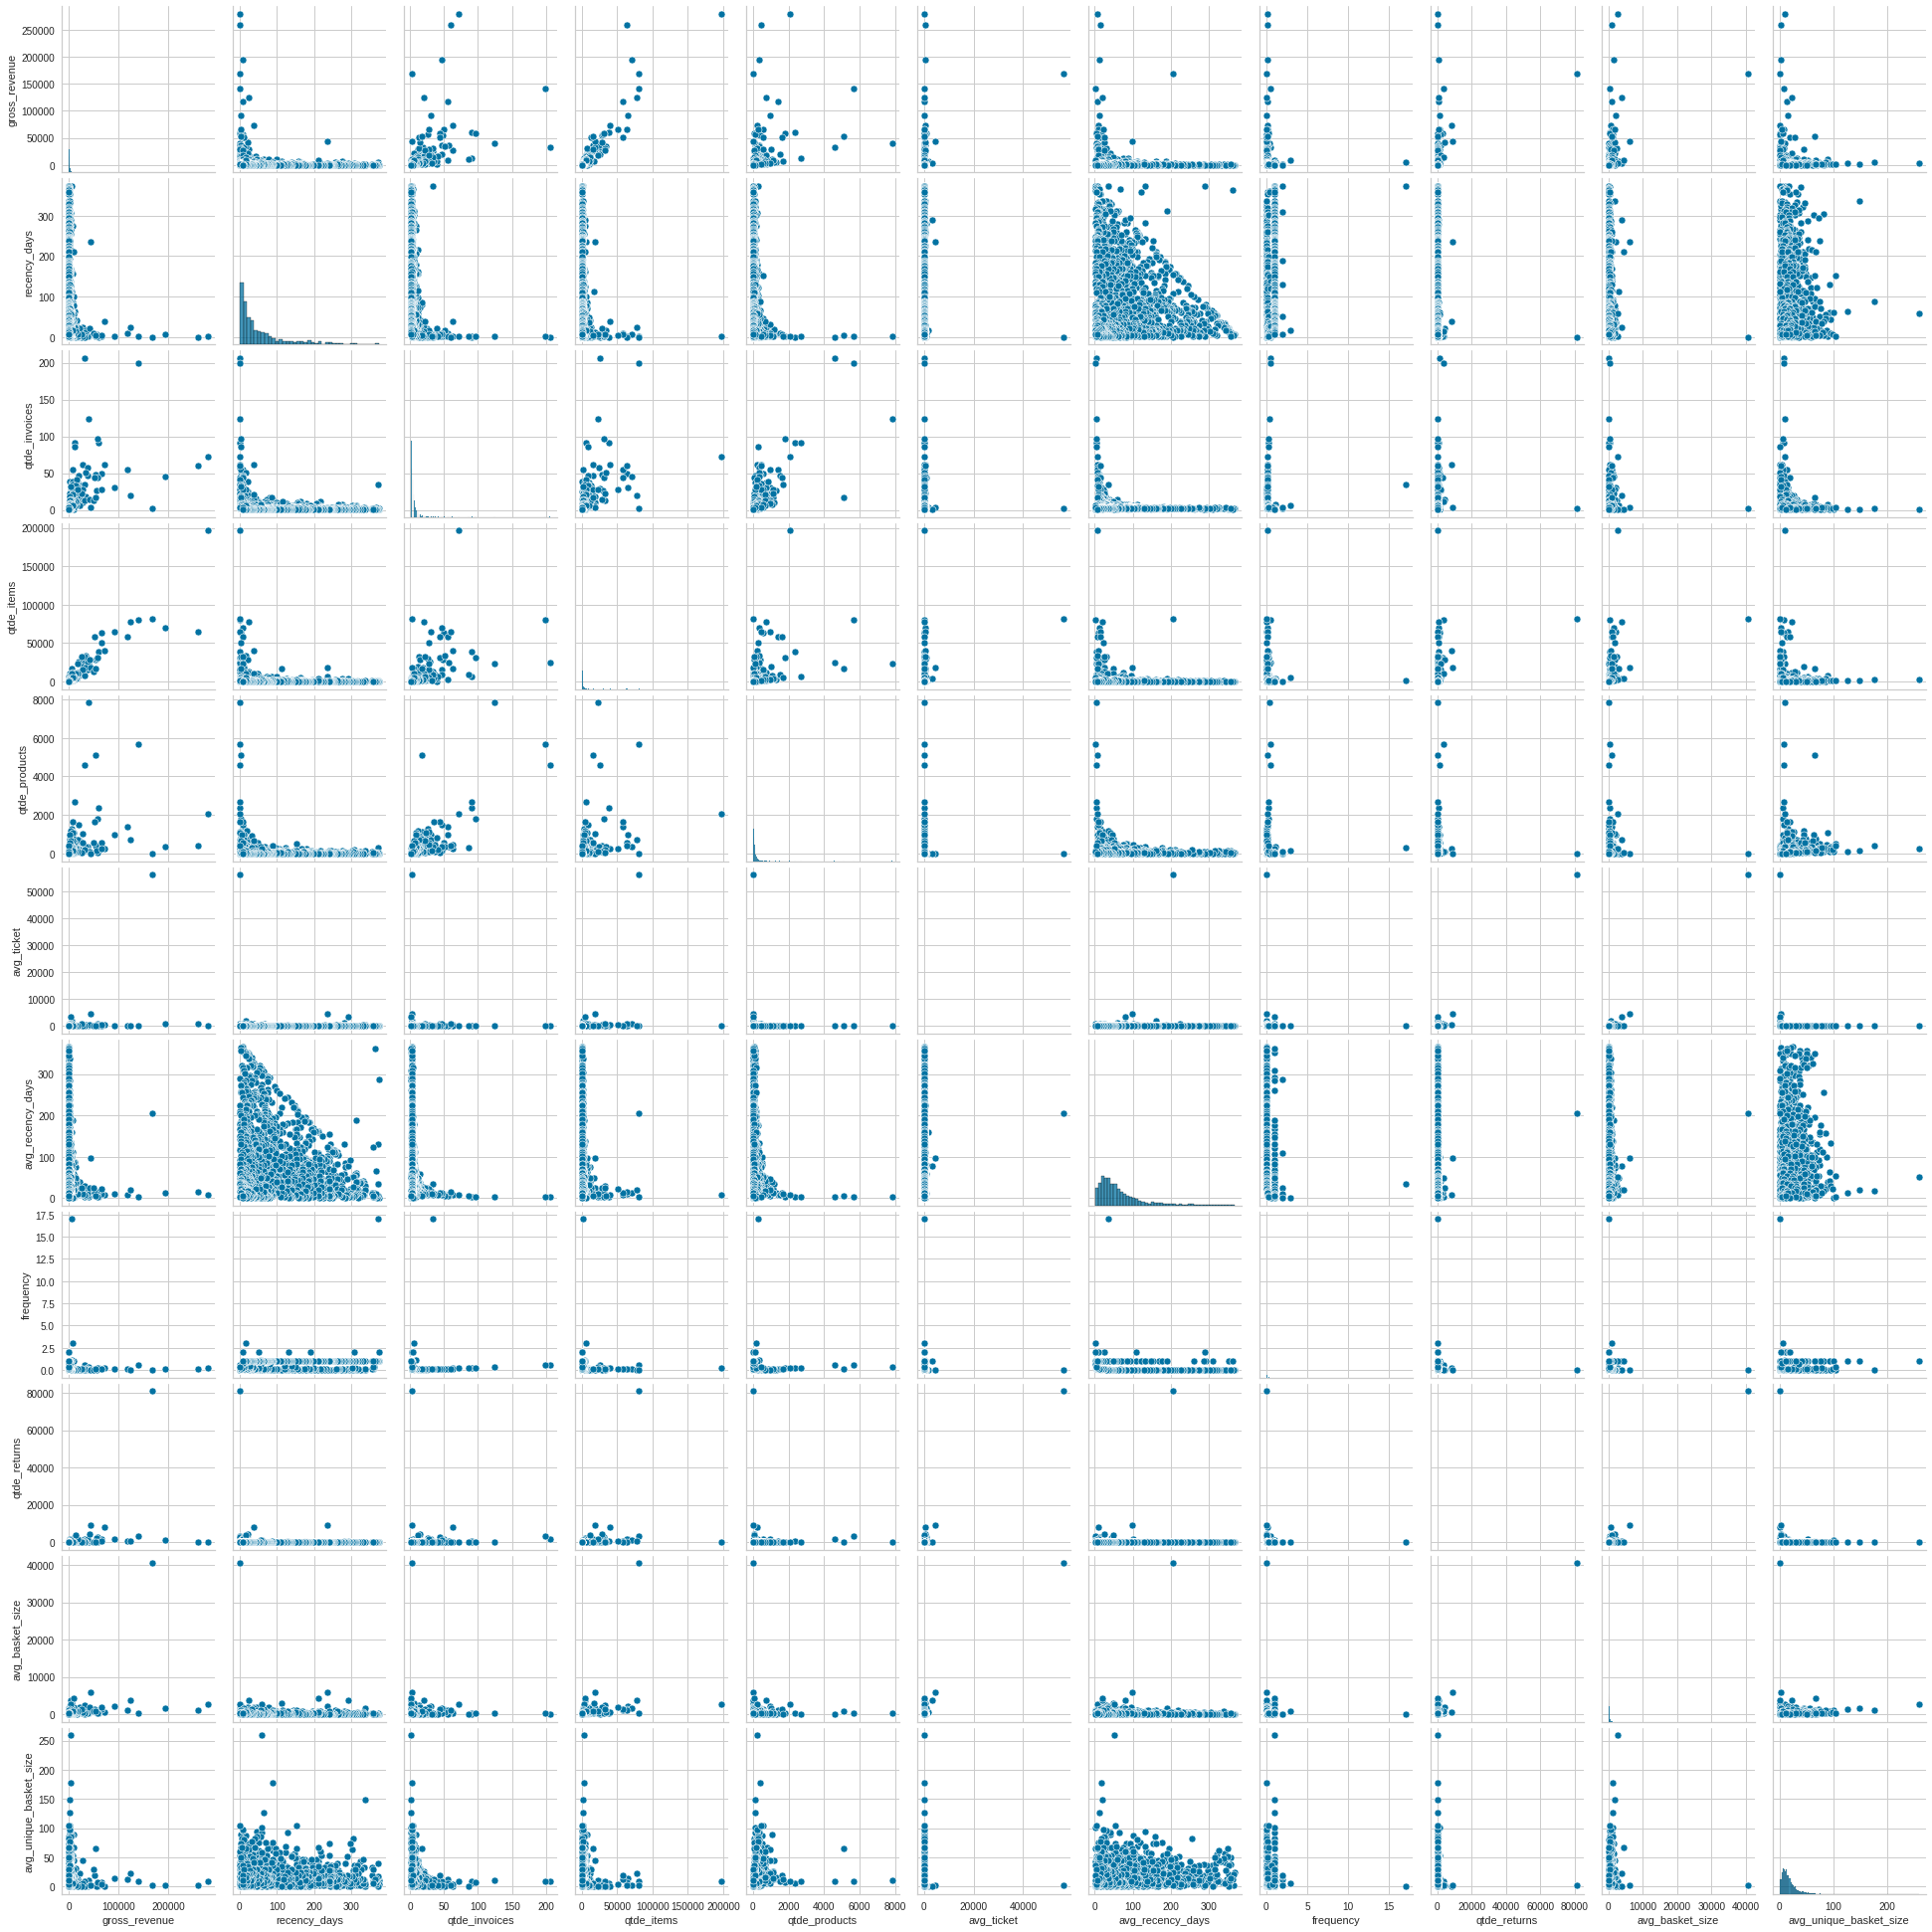

In [185]:
plt.figure( figsize=(25,12))
sns.pairplot(df42)

In [86]:
#Notes
# Frequency has low variance
# Avg Ticket has low variance

columns_not_selected = ['customer_id','frequency','avg_ticket']

## 4.3 Visualizando o espaço de dados

In [87]:
#df43 = df4.copy()
df43 = df4.drop(columns_not_selected, axis=1)

In [88]:
# Pré-Tratamento dos dados

# Instanciando os Scalers
mm = MinMaxScaler()
st = StandardScaler()

# lista de colunas
colunas = df43.columns.to_list()

# Aplicando os scalers
for col in colunas:
    df43[col] = mm.fit_transform(df43[[col]])

In [89]:
df43.head()

,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_recency_days,qtde_returns,avg_basket_size,avg_unique_basket_size
0,0.019292,0.997319,0.160976,0.008799,0.037774,0.094521,0.004438,0.008317,0.001614
1,0.011559,0.150134,0.039024,0.007056,0.021695,0.071918,0.003883,0.025539,0.044307
2,0.024000,0.005362,0.068293,0.025538,0.029479,0.060788,0.005547,0.055623,0.028594
3,0.003375,0.254692,0.019512,0.002225,0.003446,0.251142,0.000000,0.014447,0.017774
4,0.003116,0.892761,0.009756,0.000401,0.000255,0.020822,0.002441,0.004272,0.000515


### 4.3.1 - PCA

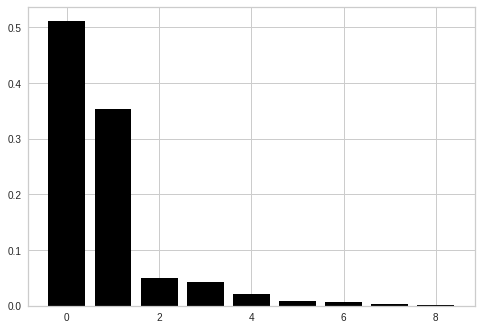

In [90]:
# Data
X = df43.copy()

# Intanciando PCA
pca = PCA(n_components = X.shape[1])

# Aplicação do PCA
principal_components = pca.fit_transform(X)

# Plot explained variance
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')

# pca component
df_pca = pd.DataFrame(principal_components)

<AxesSubplot:xlabel='0', ylabel='1'>

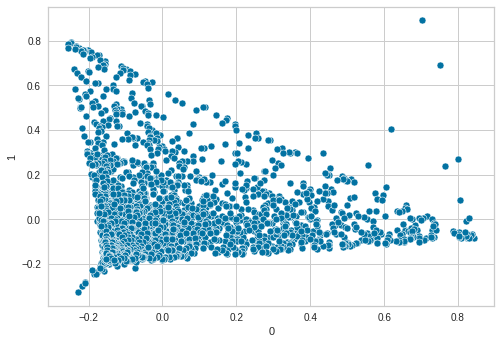

In [91]:
# Plotando o espaço de dados conforme PCA
sns.scatterplot(x=0, y=1, data=df_pca)

### 4.3.2 - UMAP

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

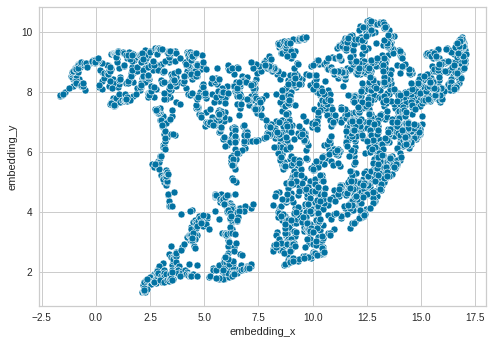

In [92]:
# Instanciando o UMAP
reducer = umap.UMAP(random_state=42 )

# Aplicando o UMAP
embedding = reducer.fit_transform(X)

# embedding
df_pca['embedding_x'] = embedding[:,0]
df_pca['embedding_y'] = embedding[:,1]

# plot UMAP
sns.scatterplot(x = 'embedding_x', y='embedding_y', data=df_pca  )

### 4.3.3 - t-SNE

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

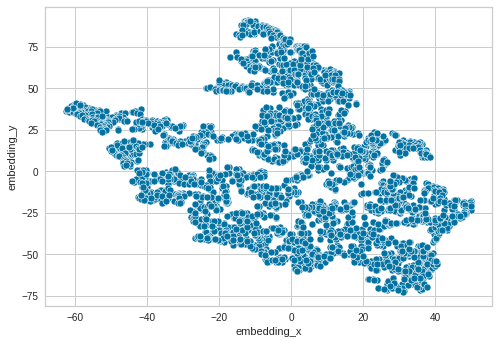

In [93]:
# Instanciando o tsne
reducer = TSNE(n_components=2, random_state=42, n_jobs=-1 )

# Aplicando o UMAP
embedding = reducer.fit_transform(X)

# embedding
df_pca['embedding_x'] = embedding[:,0]
df_pca['embedding_y'] = embedding[:,1]

# plot UMAP
sns.scatterplot(x = 'embedding_x', y='embedding_y', data=df_pca  )

### 4.3.4 - RandomForestEmbedding

In [114]:
# Data
X = df43.drop(['gross_revenue'], axis=1)
y = df43['gross_revenue']

# model definition
rf_model = RandomForestRegressor(random_state=42)

# model training
rf_model.fit(X,y)

# Leaf DataFrame
df_leafs = pd.DataFrame(rf_model.apply(X))

# Dataframe sizes
df_leafs.shape

(2969, 100)

In [115]:
df_leafs.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,2988,2722,3399,3343,2259,3273,2997,3137,3199,3092,...,3200,3226,3206,2813,3179,3141,2859,3344,3340,3327
1,2922,3109,2934,2822,2705,3011,2952,2814,2912,2993,...,2488,2774,2950,2770,3054,2876,2889,2838,2863,2747
2,3522,3615,3579,3589,3623,3621,3570,3526,3543,3630,...,3602,3471,3588,3558,3604,3578,3563,3619,3594,3658
3,1245,1803,1473,2098,1745,2096,2041,1966,1764,2006,...,1742,1122,2029,1957,1153,1299,1559,1097,2118,2132
4,15,133,21,110,21,173,169,12,47,10,...,185,75,546,53,120,70,121,25,16,81


<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

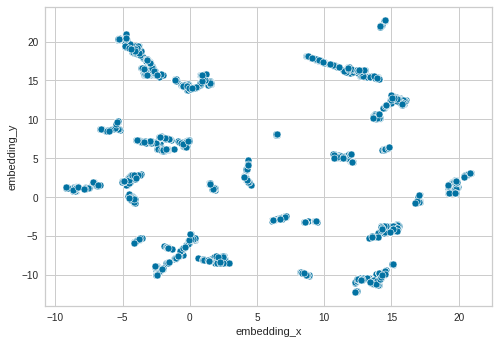

In [116]:
# Reduzer dimensionality
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(df_leafs)

# embedding
df_pca['embedding_x'] = embedding[:,0]
df_pca['embedding_y'] = embedding[:,1]

# plot UMAP
sns.scatterplot(x='embedding_x',
                y='embedding_y',
                data = df_pca)

# 5.0 Data Preparation

In [117]:
df5 = df43.copy()

In [118]:
scaler = MinMaxScaler()

for col in df5.columns.to_list():
    df5[col] = scaler.fit_transform(np.array(df5[col]).reshape(-1,1))

In [119]:
df5.head()

,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_recency_days,qtde_returns,avg_basket_size,avg_unique_basket_size
0,0.019292,0.997319,0.160976,0.008799,0.037774,0.094521,0.004438,0.008317,0.001614
1,0.011559,0.150134,0.039024,0.007056,0.021695,0.071918,0.003883,0.025539,0.044307
2,0.024000,0.005362,0.068293,0.025538,0.029479,0.060788,0.005547,0.055623,0.028594
3,0.003375,0.254692,0.019512,0.002225,0.003446,0.251142,0.000000,0.014447,0.017774
4,0.003116,0.892761,0.009756,0.000401,0.000255,0.020822,0.002441,0.004272,0.000515


# 6.0 Feature Selection

In [120]:
df6=df5.copy()

# 7.0 Hyperparameter Fine-Tunning

In [121]:
df7=df6.copy()

In [122]:
clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]

## 7.1 Within-Cluster Sum of Square (WSS)

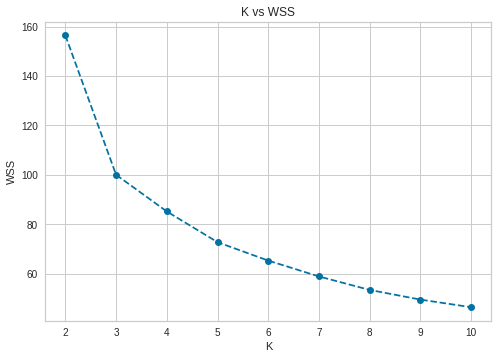

In [123]:
# Roots
wss = []
for k in clusters:
    # model definition
    kmeans = KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)
    
    # model training
    kmeans.fit(df7)
    
    # validation
    wss.append(kmeans.inertia_)
    
# plot wss - elbow method
plt.plot(clusters, wss, linestyle='--', marker='o', color='b' )
plt.xlabel('K')
plt.ylabel('WSS')
plt.title('K vs WSS');

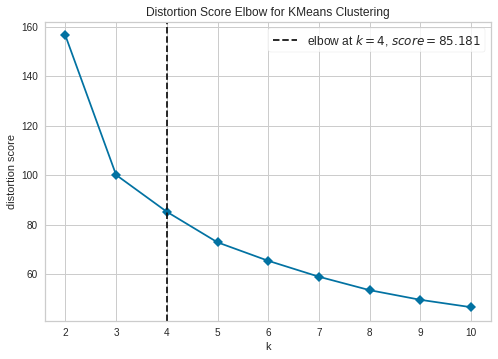

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [124]:
# Nuttela
kmeans = KElbowVisualizer( KMeans(), k=clusters, timings=False )
kmeans.fit(df6)
kmeans.show()

## 7.2 Sillhoute Score

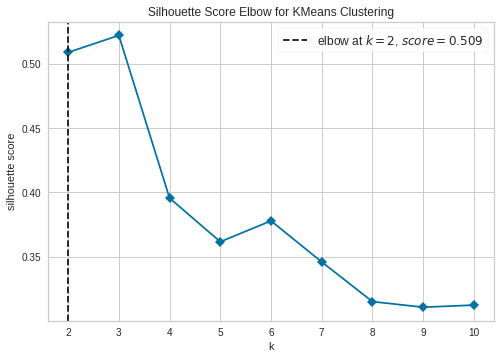

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [125]:
# Utilizando o silhoute score para encontrar o melhor valor de k
kmeans = KElbowVisualizer( KMeans(), k=clusters,metric='silhouette', timings=False )
kmeans.fit(df7)
kmeans.show()

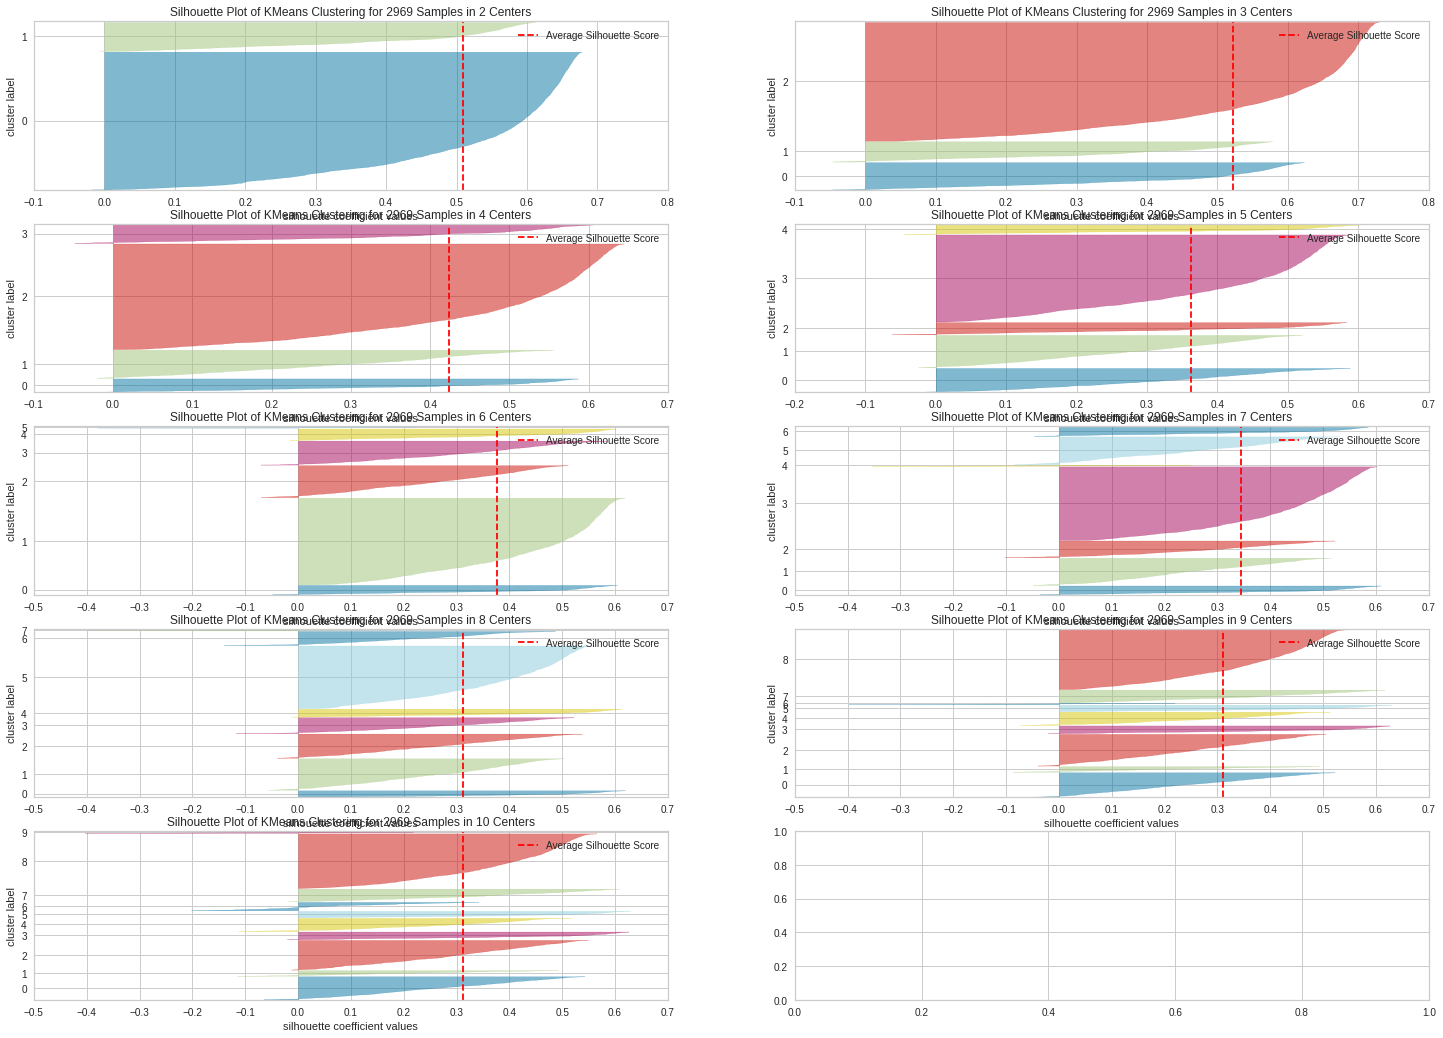

In [126]:
# Silhouette Analysis por valor de k

fig, ax = plt.subplots(5,2, figsize=(25,18))
for k in clusters:
    km = KMeans(n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(k,2)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(df7)
    visualizer.finalize()

# 8.0 ModelTraining

## Kmeans

In [127]:
#model definition
k=3
kmeans = KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)

#model training
kmeans.fit(df7)

#model clustering
labels = kmeans.labels_

## Cluster Validation

### wss (Within-cluster sum of squares)

In [128]:
print( f'WWS Value: {kmeans.inertia_}')

WWS Value: 100.0624143238056


### SS (Silhoute Score)

In [129]:
score = silhouette_score(df7, labels, metric='euclidean')
print(f'SS Value: {score}')

SS Value: 0.5222032539148347


# 9.0 Cluster Analysis

In [130]:
df9 = df7.copy()
df9['cluster'] = labels
df9.head()

,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_recency_days,qtde_returns,avg_basket_size,avg_unique_basket_size,cluster
0,0.019292,0.997319,0.160976,0.008799,0.037774,0.094521,0.004438,0.008317,0.001614,0
1,0.011559,0.150134,0.039024,0.007056,0.021695,0.071918,0.003883,0.025539,0.044307,2
2,0.024000,0.005362,0.068293,0.025538,0.029479,0.060788,0.005547,0.055623,0.028594,2
3,0.003375,0.254692,0.019512,0.002225,0.003446,0.251142,0.000000,0.014447,0.017774,2
4,0.003116,0.892761,0.009756,0.000401,0.000255,0.020822,0.002441,0.004272,0.000515,0


## 9.1 - Visualization Inspection

### 9.1.1 - Silhouette

In [132]:
# data para o visualizer
df9_aux = df9.drop('cluster', axis=1)

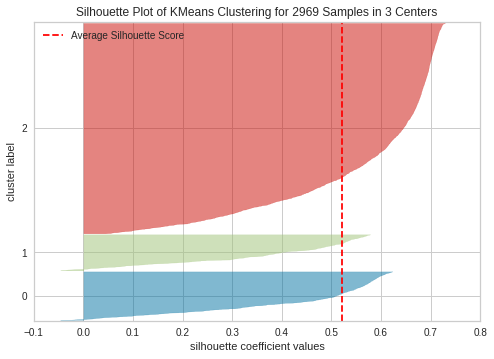

In [134]:
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(df9_aux)
visualizer.finalize()

### 9.1.2 - 2d Plot

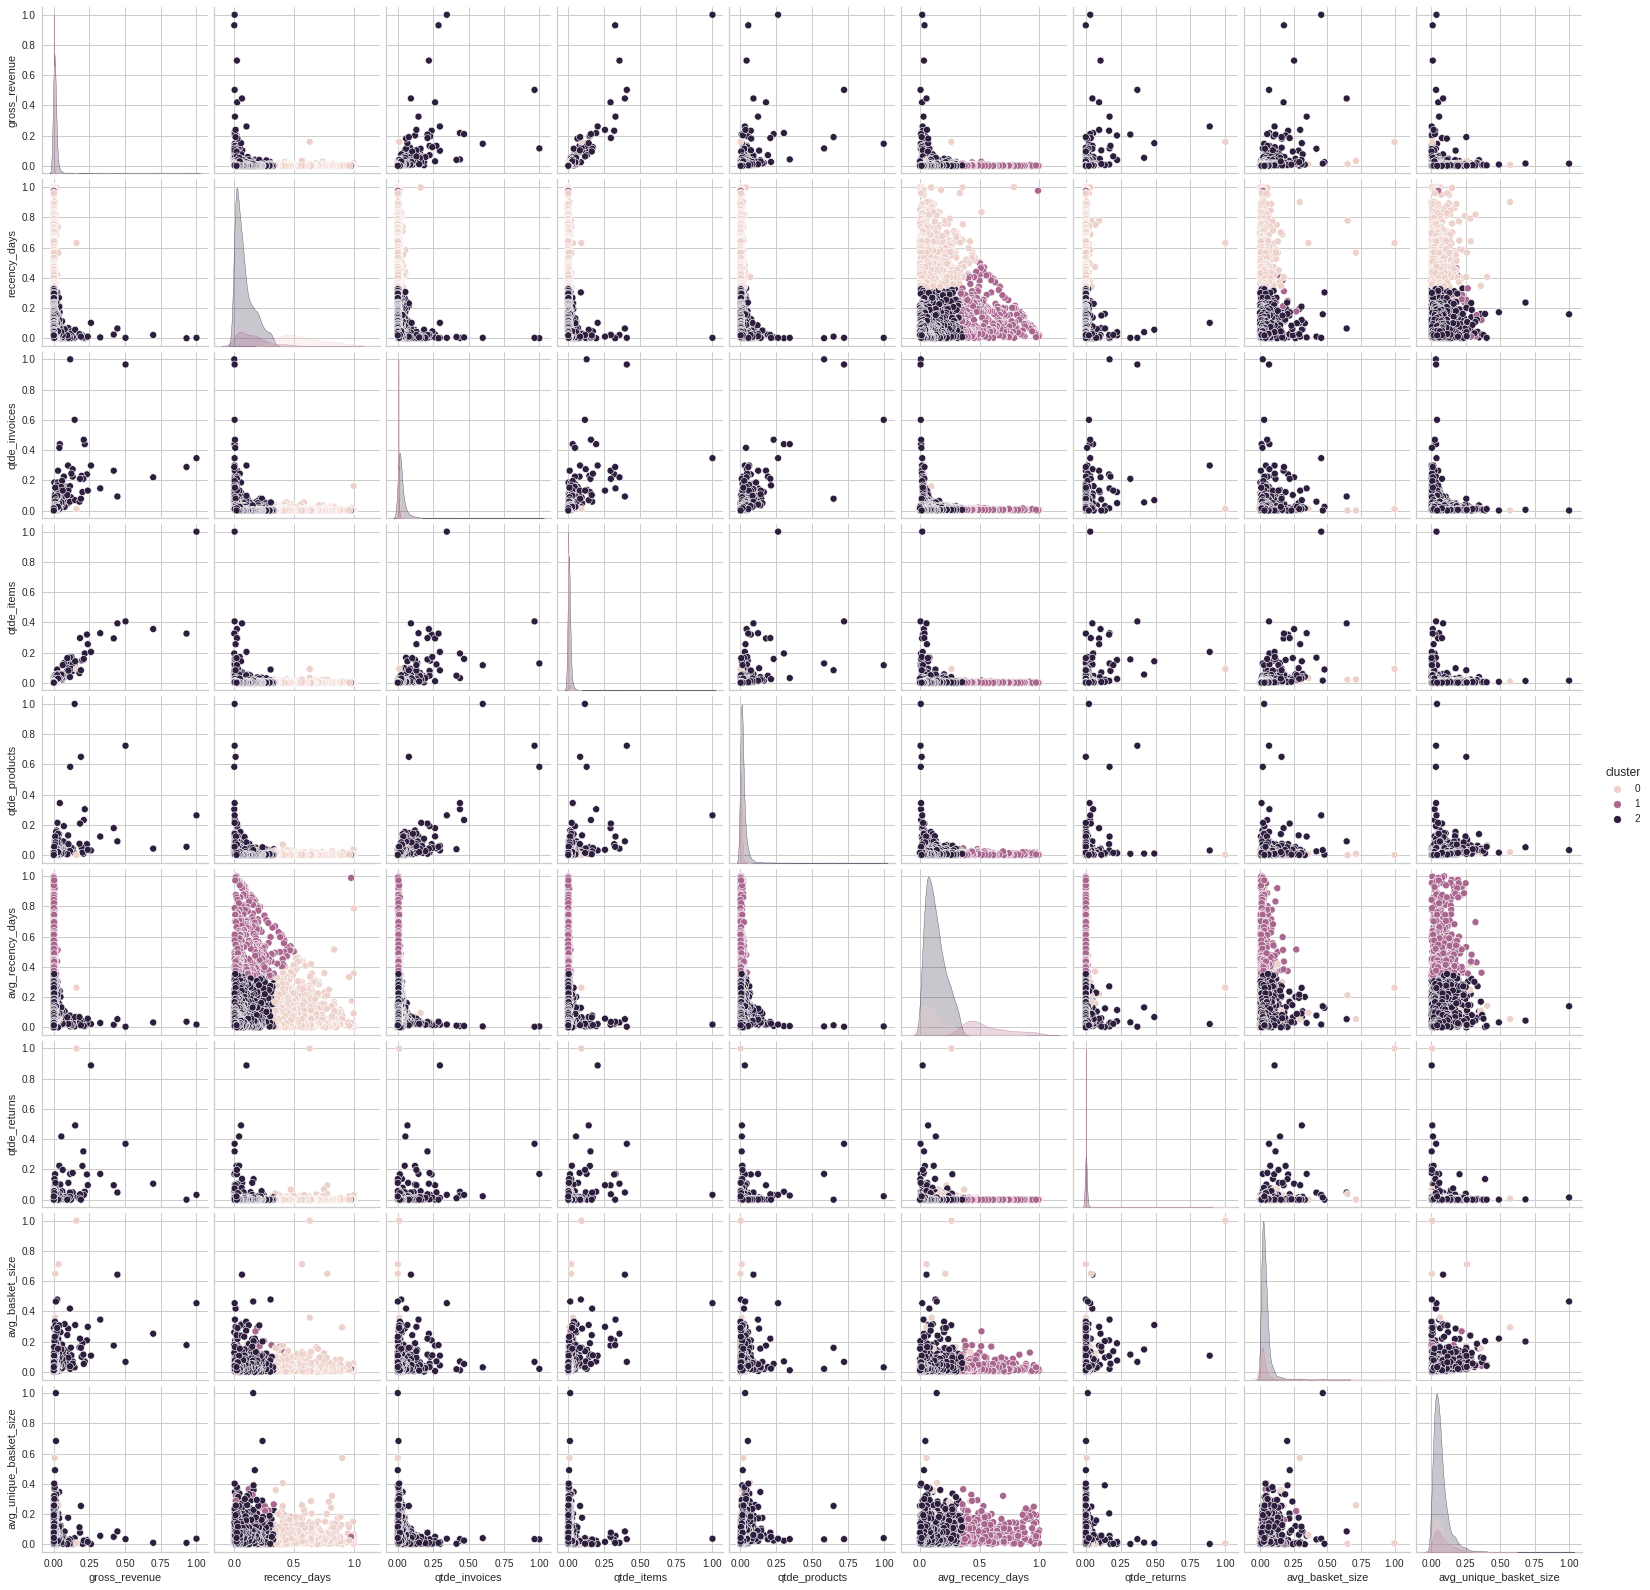

In [135]:
#df_viz = df9.drop(columns = 'customer_id', axis=1)
sns.pairplot(df9, hue='cluster')

## Cluster Profile

In [ ]:
# Number of customers
df_cluster = df9[['customer_id','cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = 100*(df_cluster['customer_id']/df_cluster['customer_id'].sum())

# Avg Gross revenue
df_avg_gross_revenue = df9[['gross_revenue','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_gross_revenue, how='inner', on='cluster')

# Avg rececy days
df_avg_recency_days = df9[['recency_days','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_recency_days, how='inner', on='cluster')

# Avg invoice_no
df_avg_invoice_no = df9[['invoice_no','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_invoice_no, how='inner', on='cluster')

# Avg Ticket
df_ticket = df9[['avg_ticket', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_ticket, how='inner', on='cluster')

# Report
df_cluster

**Cluster 01: (Candidatos a Insider)**

   - Número de customers: 6 (0,14% do customers)
   - Recência em média: 7 dias
   - Compras em média: 89 compras
   - Receita em média: $182.182,00 dólares
    
**Cluster 02:**

   - Números de customers: 31 (0,71% dos customers)
   - Recência em média: 14 dias
   - Compras em média: 53 compras
   - Receita em média: $40.543,52 dólares
   
**Cluster 03:**

   - Número de customers: 4.335 (99% do customers)
   - Recência em média: 92 dias
   - Compras em médias: 5 compras
   - Receita em média: $1.372,57 dólares

# 10.0 Deploy in production